In [51]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import scipy.signal
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)

import os
from datetime import datetime, timedelta

from rakott.mpl import fig_panel_labels, fig_xlabel, fig_ylabel, savefig_bbox

In [11]:
def int_to_dt(t):
    return pd.to_datetime(start_date) + timedelta(days=t)
def date_to_int(x):
    dt = datetime.strptime(x + ' 2020', '%b %d %Y')
    td = dt - start_date
    return td.days
def date_to_date(x):
    dt = datetime.strptime(x + ' 2020', '%b %d %Y')
    return dt
def τ_to_string(τ):
    return (pd.to_datetime(start_date) + timedelta(days=τ)).strftime('%b %d')

from inference import find_start_day, get_first_NPI_date, get_last_NPI_date, params_bounds
from model.normal_prior_model import NormalPriorModel
from model.fixed_tau_model import FixedTauModel
from model.normal_prior_model import NormalPriorModel

from Fig_ppc import load_chain

In [12]:
job_id = '7M' 
country = 'Italy'

output_folder = r'/home/ubuntu/output-tmp'
table_path = os.path.join(output_folder, job_id, 'tables', 'all-countries-{}.csv'.format(job_id))
df = pd.read_csv(table_path)
df = df.rename(columns={'official_τ': 'τ official'})
df['country'] = df['country'].str.replace("_", " ")
df = df[df['country'] == country]
print(df.columns)
df

Index(['country', 'WAIC', 'DIC using median', 'DIC using mean',
       'DIC using MAP', 'loglik(MAP)', 'loglik(mean)', 'loglik(median)', 'N',
       'p_steps', 'p_model_type', 'p_Td1', 'p_Td2', 'τ official', 'τ mean d',
       'τ median d', 'τ MAP d', 'τ hpd 75% from', 'τ hpd 75% to',
       'τ hpd 95% from', 'τ hpd 95% to', 'official τ from 1 Jan',
       'τ mean from 1 Jan', 'τ median from 1 Jan', 'τ MAP from 1 Jan',
       'τ CrI median (75%)', 'τ CrI median (95%)', 'τ CrI mean (75%)',
       'τ CrI mean (95%)', 'Z mean', 'Z median', 'Z MAP', 'D mean', 'D median',
       'D MAP', 'μ mean', 'μ median', 'μ MAP', 'β mean', 'β median', 'β MAP',
       'α1 mean', 'α1 median', 'α1 MAP', 'λ mean', 'λ median', 'λ MAP',
       'α2 mean', 'α2 median', 'α2 MAP', 'E0 mean', 'E0 median', 'E0 MAP',
       'Iu0 mean', 'Iu0 median', 'Iu0 MAP', 'Δt0 mean', 'Δt0 median',
       'Δt0 MAP', 'τ mean', 'τ median', 'τ MAP', 'τ hpd 75% from n',
       'τ hpd 75% to n', 'τ hpd 95% from n', 'τ hpd 95% to n',

,country,WAIC,DIC using median,DIC using mean,DIC using MAP,loglik(MAP),loglik(mean),loglik(median),N,p_steps,...,Δt0 MAP,τ mean,τ median,τ MAP,τ hpd 75% from n,τ hpd 75% to n,τ hpd 95% from n,τ hpd 95% to n,τ hpd CrI 75%,τ hpd CrI 95%
1,Italy,79.9437,-32250.9561,-2490.0998,84.5907,-32.576,-1319.9212,-16200.3494,60431283,7000000,...,1.0366,30.3904,29.9537,32.7866,29.0,32.4515,27.9473,33.0,3.4515,5.0527


In [13]:
Z, D, μ, β, α, _, _, E0, Iu0, Δt0, τ = df[['Z median', 'D median', 'μ median', 'β median', 'α1 median', 'λ median', 'α2 median', 'E0 median', 'Iu0 median', 'Δt0 median', 'τ median']].values[0].tolist()
τ_star_days = df['official τ from 1 Jan'].values[0]

In [14]:
url = 'https://github.com/ImperialCollegeLondon/covid19model/raw/v1.0/data/COVID-19-up-to-date.csv'
fname = '../data/COVID-19-up-to-date.csv'
if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)
data = pd.read_csv(fname, encoding='iso-8859-1')
data['date'] = pd.to_datetime(data['dateRep'], format='%d/%m/%Y')
data = data[data['countriesAndTerritories'] == country]
N = data.iloc[0]['popData2018']
cases_and_dates = data.iloc[::-1][['cases','date']]
start_date = find_start_day(cases_and_dates)
X = np.array(cases_and_dates[cases_and_dates['date'] >= start_date]['cases'])
ndays = len(X)

In [15]:
start_date = find_start_day(cases_and_dates)
chain_fname = os.path.join(output_folder, job_id, 'inference', '{}.npz'.format(country))
load = load_chain(fname=chain_fname)
chain = load[0]
logliks = load[1]


In [26]:

# found = False
# i = 0 
# while not found:
#     params = chain[i]
#     if round(params[-1])==round(τ):
#         break
#     i = i+1

In [53]:
model = FixedTauModel(country, X, start_date, N, 
                        get_last_NPI_date(country), get_first_NPI_date(country),
                        params_bounds, 9, 6)

y_star = np.array([
    model.generate_daily_cases(θi)
    for θi in 1000*[params[:-1]]
])

model.τ = τ
y_hat = np.array([
    model.generate_daily_cases(θi)
    for θi in 1000*[params[:-1]]
])

In [54]:
X_mean = scipy.signal.savgol_filter(X, 3, 1)

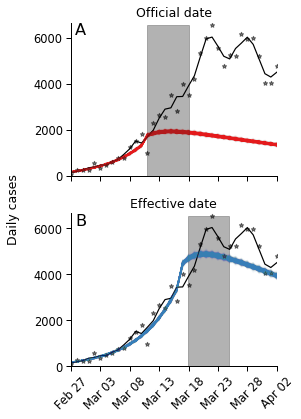

In [69]:
max_vline = 0.9
ymax = X.max()
τ_star_days = (get_last_NPI_date(country) - start_date).days

fig, axes = plt.subplots(2, 1, figsize=(4, 6), sharex=True, sharey=True)

t = range(0, ndays)
for ax in axes.flat:
    ax.plot(t, X, '*', color='k', alpha=0.5)
    ax.plot(t, X_mean, '-', color='k')

ax = axes[0]
ax.set_title('Official date')
ax.plot(t, y_star.T, color=red, alpha=0.01)
# ax.fill_between(t, y_starlow, y_starhigh, color=red, alpha=0.5)
# ax.axvline(τ_star_days, ymax=max_vline, color=red,   ls='-', lw=3)
# ax.axvline(τ_star_days+7, ymax=max_vline, color=red,   ls='-', lw=3)
ax.fill_between([τ_star_days, τ_star_days+7], 0, ymax, color='k', alpha=0.3)

ax = axes[1]
ax.set_title('Effective date')
ax.plot(t, y_hat.T, color=blue, alpha=0.01)
# ax.fill_between(t, y_hatlow, y_hathigh, color=blue, alpha=0.5)
# ax.axvline(τ, ymax=max_vline, color=blue, ls='-', lw=3)
# ax.axvline(τ+7, ymax=max_vline, color=blue, ls='-', lw=3)
ax.fill_between([τ, τ+7], 0, ymax, color='k', alpha=0.3)

days = t[::5]
labels = [τ_to_string(d) for d in days]
ax.set_xticks(days)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlim(10, 45)
ax.set_ylim(0, ymax+100)
txt = fig_ylabel(fig, 'Daily cases')

fig.tight_layout()
# fig.suptitle(country)
fig_panel_labels(axes, xcoord=0.02)
sns.despine()
fig.savefig('../../output-tmp/fig5_45.pdf', dpi=100, **savefig_bbox(txt))